In [ ]:
!pip install noisereduce librosa pandas numpy h5py tqdm -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Gathering

In [ ]:
import os
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

import noisereduce as nr

from concurrent.futures import ProcessPoolExecutor
import multiprocessing

class AudioBulkProcessor:
    """
    Process bulk audio files with normalization, noise reduction, and silence removal
    """

    def __init__(self, target_sr=16000, n_jobs=-1):
        """
        Args:
            target_sr: Target sample rate for all audio
            n_jobs: Number of parallel jobs (-1 for all cores)
        """
        self.target_sr = target_sr
        self.n_jobs = multiprocessing.cpu_count() if n_jobs == -1 else n_jobs

    def process_file(self, input_path, output_path=None,
                    normalize=True, noise_reduce=True,
                    remove_silence=True, **kwargs):
        """
        Process single audio file

        Args:
            input_path: Path to input audio file
            output_path: Path to save processed audio (None for in-place)
            normalize: Apply normalization
            noise_reduce: Apply noise reduction
            remove_silence: Remove leading/trailing silence
            **kwargs: Additional parameters for each processing step
        """
        try:
            # Load audio
            audio, sr = librosa.load(input_path, sr=None)

            # Resample if needed
            if sr != self.target_sr:
                audio = librosa.resample(y=audio, orig_sr=sr, target_sr=self.target_sr)
                sr = self.target_sr

            # Apply processing steps
            if remove_silence:
                audio = self._remove_silence(audio, sr, **kwargs.get('silence_params', {}))

            if noise_reduce:
                audio = self._reduce_noise(audio, sr, **kwargs.get('noise_params', {}))

            if normalize:
                audio = self._normalize_audio(audio, **kwargs.get('norm_params', {}))

            # Determine output path
            if output_path is None:
                output_path = input_path  # Overwrite original

            # Save processed audio
            sf.write(output_path, audio, sr)

            return True, output_path, len(audio)/sr

        except Exception as e:
            return False, str(e), 0

    def process_directory(self, input_dir, output_dir=None,
                         file_extensions=('.wav', '.mp3', '.flac'),
                         **process_kwargs):
        """
        Process all audio files in a directory

        Args:
            input_dir: Input directory path
            output_dir: Output directory path (None for in-place)
            file_extensions: Tuple of file extensions to process
            **process_kwargs: Parameters for process_file method
        """
        # Get all audio files
        input_paths = []
        for ext in file_extensions:
            input_paths.extend(Path(input_dir).rglob(f'*{ext}'))
            input_paths.extend(Path(input_dir).rglob(f'*{ext.upper()}'))

        input_paths = [str(p) for p in input_paths]

        print(f"Found {len(input_paths)} audio files to process")

        # Create output directory if specified
        if output_dir:
            Path(output_dir).mkdir(parents=True, exist_ok=True)

        # Process files
        results = []

        if self.n_jobs > 1:
            # Parallel processing
            with ProcessPoolExecutor(max_workers=self.n_jobs) as executor:
                futures = []
                for input_path in input_paths:
                    # Determine output path
                    if output_dir:
                        rel_path = Path(input_path).relative_to(input_dir)
                        output_path = Path(output_dir) / rel_path
                        output_path.parent.mkdir(parents=True, exist_ok=True)
                        output_path = str(output_path)
                    else:
                        output_path = input_path

                    futures.append(
                        executor.submit(
                            self._process_file_wrapper,
                            input_path, output_path, **process_kwargs
                        )
                    )

                # Collect results with progress bar
                for future in tqdm(futures, desc="Processing audio files"):
                    results.append(future.result())
        else:
            # Sequential processing
            for input_path in tqdm(input_paths, desc="Processing audio files"):
                if output_dir:
                    rel_path = Path(input_path).relative_to(input_dir)
                    output_path = Path(output_dir) / rel_path
                    output_path.parent.mkdir(parents=True, exist_ok=True)
                    output_path = str(output_path)
                else:
                    output_path = input_path

                result = self._process_file_wrapper(input_path, output_path, **process_kwargs)
                results.append(result)

        # Summary statistics
        successful = [r for r in results if r[0]]
        failed = [r for r in results if not r[0]]

        print(f"\nProcessing Complete:")
        print(f"  Successful: {len(successful)} files")
        print(f"  Failed: {len(failed)} files")

        if failed:
            print("\nFailed files:")
            for failure in failed[:10]:  # Show first 10 failures
                print(f"  {failure[1]}")
            if len(failed) > 10:
                print(f"  ... and {len(failed)-10} more")

        return results

    def _process_file_wrapper(self, *args, **kwargs):
        """Wrapper for parallel processing"""
        return self.process_file(*args, **kwargs)

    # Processing methods
    def _normalize_audio(self, audio, method='peak', target_level=-1.0,
                        loudness_level=-23.0):
        """
        Normalize audio

        Args:
            audio: Input audio array
            method: 'peak', 'rms', or 'loudness'
            target_level: Target peak level in dB (for peak normalization)
            loudness_level: Target LUFS level (for loudness normalization)
        """
        if method == 'peak':
            # Peak normalization to target level
            peak = np.max(np.abs(audio))
            if peak > 0:
                target_linear = 10**(target_level / 20)
                audio = audio * (target_linear / peak)

        elif method == 'rms':
            # RMS normalization
            rms = np.sqrt(np.mean(audio**2))
            target_rms = 10**(target_level / 20)
            if rms > 0:
                audio = audio * (target_rms / rms)

        elif method == 'loudness':
            # Loudness normalization (requires pydub)
            try:
                from pydub import AudioSegment
                from pydub.effects import normalize
                import io

                # Convert numpy array to AudioSegment
                audio_segment = AudioSegment(
                    audio.tobytes(),
                    frame_rate=self.target_sr,
                    sample_width=audio.dtype.itemsize,
                    channels=1
                )

                # Apply loudness normalization
                audio_segment = normalize(audio_segment, headroom=0.1)

                # Convert back to numpy
                audio = np.array(audio_segment.get_array_of_data())
                audio = audio.astype(np.float32) / (2**15)  # For 16-bit audio

            except ImportError:
                print("Warning: pydub not installed, using peak normalization instead")
                peak = np.max(np.abs(audio))
                if peak > 0:
                    audio = audio / peak

        # Apply safety ceiling
        audio = np.clip(audio, -0.99, 0.99)

        return audio

    def _reduce_noise(self, audio, sr, method='spectral_gate',
                     stationary=True, prop_decrease=1.0,
                     freq_mask_smooth_hz=500, time_mask_smooth_ms=50):
        """
        Reduce noise in audio

        Args:
            audio: Input audio array
            sr: Sample rate
            method: 'spectral_gate', 'wiener', or 'none'
            stationary: Whether noise is stationary
            prop_decrease: Proportion of noise to decrease (0-1)
        """
        if method == 'spectral_gate':
            # Spectral subtraction using noisereduce
            try:
                # Estimate noise from first 500ms
                noise_sample = audio[:int(0.5 * sr)]

                audio_clean = nr.reduce_noise(
                    y=audio,
                    sr=sr,
                    y_noise=noise_sample,
                    stationary=stationary,
                    prop_decrease=prop_decrease,
                    freq_mask_smooth_hz=freq_mask_smooth_hz,
                    time_mask_smooth_ms=time_mask_smooth_ms
                )
                return audio_clean
            except:
                return audio

        elif method == 'wiener':
            # Wiener filter approach
            try:
                from scipy import signal

                # Estimate noise spectrum
                noise_sample = audio[:int(0.5 * sr)]
                f, Pxx = signal.welch(noise_sample, sr, nperseg=1024)

                # Apply Wiener filter
                audio_fft = np.fft.rfft(audio)
                freq = np.fft.rfftfreq(len(audio), 1/sr)

                # Interpolate noise PSD to match audio frequencies
                noise_psd = np.interp(freq, f, Pxx, left=Pxx[0], right=Pxx[-1])

                # Wiener filter
                signal_psd = np.abs(audio_fft)**2
                wiener_filter = signal_psd / (signal_psd + noise_psd)
                audio_clean_fft = audio_fft * wiener_filter
                audio_clean = np.fft.irfft(audio_clean_fft, n=len(audio))

                return audio_clean
            except:
                return audio

        else:
            return audio

    def _remove_silence(self, audio, sr, top_db=30, frame_length=2048,
                       hop_length=512, ref=np.max):
        """
        Remove leading and trailing silence

        Args:
            audio: Input audio array
            sr: Sample rate
            top_db: Threshold in dB below reference
            frame_length: Length of the frame for STFT
            hop_length: Hop length for STFT
            ref: Reference power for dB calculation
        """
        # Trim silence using librosa
        audio_trimmed, _ = librosa.effects.trim(
            audio,
            top_db=top_db,
            frame_length=frame_length,
            hop_length=hop_length,
            ref=ref
        )

        # If trimming removed everything, return original
        if len(audio_trimmed) == 0:
            return audio

        return audio_trimmed

    def _remove_silence_vad(self, audio, sr, aggressiveness=3):
        """
        Remove silence using Voice Activity Detection (WebRTC VAD)

        Args:
            audio: Input audio array
            sr: Sample rate
            aggressiveness: VAD aggressiveness (0-3)
        """
        try:
            import webrtcvad
            from scipy.io import wavfile

            # VAD requires 16-bit PCM at 8kHz, 16kHz, 32kHz, or 48kHz
            vad = webrtcvad.Vad(aggressiveness)

            # Resample to 16kHz if needed
            if sr != 16000:
                audio = librosa.resample(y=audio, orig_sr=sr, target_sr=16000)
                sr = 16000

            # Convert to 16-bit PCM
            audio_int16 = (audio * 32767).astype(np.int16)

            # Frame parameters for VAD
            frame_duration = 30  # ms
            frame_size = int(sr * frame_duration / 1000)

            # Split into frames
            frames = []
            for i in range(0, len(audio_int16), frame_size):
                frame = audio_int16[i:i+frame_size]
                if len(frame) < frame_size:
                    # Pad last frame
                    frame = np.pad(frame, (0, frame_size - len(frame)))
                frames.append(frame)

            # Detect speech frames
            speech_frames = []
            for frame in frames:
                is_speech = vad.is_speech(frame.tobytes(), sr)
                speech_frames.append(is_speech)

            # Find speech segments
            speech_segments = []
            in_speech = False
            start_idx = 0

            for i, is_speech in enumerate(speech_frames):
                if is_speech and not in_speech:
                    start_idx = i * frame_size
                    in_speech = True
                elif not is_speech and in_speech:
                    end_idx = i * frame_size
                    speech_segments.append((start_idx, end_idx))
                    in_speech = False

            # If still in speech at end
            if in_speech:
                speech_segments.append((start_idx, len(audio_int16)))

            # Extract speech segments
            if speech_segments:
                speech_audio = np.concatenate([
                    audio_int16[start:end]
                    for start, end in speech_segments
                ])
                # Convert back to float
                speech_audio = speech_audio.astype(np.float32) / 32767
            else:
                speech_audio = audio_int16.astype(np.float32) / 32767

            # Resample back to original rate if needed
            if sr != self.target_sr:
                speech_audio = librosa.resample(
                    y=speech_audio,
                    orig_sr=sr,
                    target_sr=self.target_sr
                )

            return speech_audio

        except ImportError:
            print("Warning: webrtcvad not installed, using librosa trim")
            return self._remove_silence(audio, sr)

In [ ]:
# quick_process.py
from pathlib import Path

def quick_bulk_process(input_folder, output_folder=None):
    """
    One-line bulk processing for common use cases
    """
    if output_folder is None:
        output_folder = Path(input_folder) / 'processed'

    # Create processor
    processor = AudioBulkProcessor(target_sr=16000, n_jobs=1)

    # Process
    results = processor.process_directory(
        input_dir=input_folder,
        output_dir=output_folder,
        normalize=True,
        noise_reduce=True,
        remove_silence=True,
        norm_params={'method': 'peak', 'target_level': -1.0},
        noise_params={'method': 'spectral_gate', 'prop_decrease': 0.9},
        silence_params={'top_db': 25}
    )

    print(f"Processed {len([r for r in results if r[0]])} files")
    print(f"Output saved to: {output_folder}")

    return results

if __name__ == '__main__':
    quick_bulk_process('Emotion Speech Dataset/')
    quick_bulk_process('TESS/')
    quick_bulk_process('jl-corpus/')

# Feature Extraction

In [ ]:
 # =====================
# 1. SETUP AND CONFIGURATION
# =====================

import os
import numpy as np
import pandas as pd
import librosa
import h5py
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
TARGET_EMOTIONS = ['sad', 'happy', 'angry', 'surprise', 'neutral']

# Paths to your datasets
DATASET_PATHS = {
    'jl-corpus': '/Users/omari/Master Classes/ML/jl-corpus/processed',
    'TESS': '/Users/omari/Master Classes/ML/TESS/processed',
    'ESD': '/Users/omari/Master Classes/ML/Emotion Speech Dataset/processed'
}

# =====================
# 2. EMOTION MAPPING AND STANDARDIZATION
# =====================

# Comprehensive emotion mapping dictionary
EMOTION_MAPPING = {
    # Standard emotions (already correct)
    'sad': 'sad',
    'happy': 'happy',
    'angry': 'angry',
    'surprise': 'surprise',
    'neutral': 'neutral',

    # TESS specific variations
    'pleasant_surprise': 'surprise',
    'pleasant surprise': 'surprise',
    'ps': 'surprise',  # TESS abbreviation
    'fear': 'surprise',  # Map fear to surprise for consistency
    'disgust': 'angry',  # Map disgust to angry
    'fearful': 'surprise',
    'disgusted': 'angry',

    # Adjective/Noun variations
    'sadness': 'sad',
    'happiness': 'happy',
    'anger': 'angry',
    'surprised': 'surprise',

    # ESD variations
    'Surprise': 'surprise',
    'Angry': 'angry',
    'Happy': 'happy',
    'Sad': 'sad',
    'Neutral': 'neutral',

    # JL Corpus variations
    'SAD': 'sad',
    'HAPPY': 'happy',
    'ANGRY': 'angry',
    'SURPRISE': 'surprise',
    'NEUTRAL': 'neutral',

    # Additional common variations
    'joy': 'happy',
    'joyful': 'happy',
    'angryanger': 'angry',
    'neutralneutral': 'neutral',
}

def standardize_emotion(input_emotion, filename, dataset_name):
    """
    Standardize emotion names across all datasets
    """
    if not input_emotion:
        return None

    input_lower = input_emotion.lower().strip().replace(' ', '_')

    # Direct mapping first
    if input_lower in EMOTION_MAPPING:
        return EMOTION_MAPPING[input_lower]

    # Check for partial matches
    for key in EMOTION_MAPPING:
        if key in input_lower:
            return EMOTION_MAPPING[key]

    # Dataset-specific heuristics
    if dataset_name == 'TESS':
        # TESS patterns: OAF_back_angry.wav or YAF_back_sad.wav
        for emotion in TARGET_EMOTIONS:
            if f'_{emotion}' in filename.lower() or f'-{emotion}' in filename.lower():
                return emotion

    elif dataset_name == 'jl-corpus':
        # JL patterns: filename contains emotion
        for emotion in TARGET_EMOTIONS:
            if emotion in filename.lower():
                return emotion

    return None

def extract_emotion_from_path(file_path, dataset_name):
    """
    Extract emotion from file path based on dataset structure
    """
    filename = os.path.basename(file_path).lower()
    parent_dir = os.path.basename(os.path.dirname(file_path)).lower()

    emotion = None

    # 1. JL Corpus: Emotion in filename
    if dataset_name == 'jl-corpus':
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in filename:
                emotion = target_emotion
                break

    # 2. ESD: Emotion in folder name
    elif dataset_name == 'ESD':
        # ESD structure: .../Angry/001/... or .../Surprise/002/...
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in parent_dir:
                emotion = target_emotion
                break

    # 3. TESS: Both folder and filename contain emotion
    elif dataset_name == 'TESS':
        # Check folder first (TESS has emotion folders)
        folder_emotions = []
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in parent_dir:
                folder_emotions.append(target_emotion)

        # Check filename
        file_emotions = []
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in filename:
                file_emotions.append(target_emotion)

        # Prioritize folder emotion, fallback to filename
        if folder_emotions:
            emotion = folder_emotions[0]
        elif file_emotions:
            emotion = file_emotions[0]
        else:
            # Check for TESS specific patterns
            if 'ps' in filename or 'pleasant' in filename:
                emotion = 'surprise'
            elif 'fear' in filename or parent_dir:
                emotion = 'surprise'
            elif 'disgust' in filename or parent_dir:
                emotion = 'angry'

    return emotion

# =====================
# 3. FEATURE EXTRACTION FUNCTIONS
# =====================

def extract_mfcc_features(audio_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Extract MFCC features from audio file
    """
    try:
        # Load audio
        audio, _ = librosa.load(audio_path, sr=sr, mono=True)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=n_mfcc,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )

        # Transpose to get (time_steps, features)
        mfccs = mfccs.T

        # Pad/trim to fixed length (3 seconds at target sample rate)
        target_length = int(3 * sr / HOP_LENGTH)  # ~129 frames for 3s
        if mfccs.shape[0] > target_length:
            mfccs = mfccs[:target_length]
        else:
            padding = target_length - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, padding), (0, 0)), mode='constant')

        return mfccs.astype(np.float32)

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def scan_audio_files(dataset_paths):
    """
    Scan all datasets and collect audio files with their standardized emotions
    """
    all_files = []

    for dataset_name, base_path in dataset_paths.items():
        if not os.path.exists(base_path):
            print(f"⚠️ Dataset path not found: {base_path}")
            continue

        print(f"\n📁 Scanning {dataset_name}...")

        # Collect all audio files
        audio_extensions = ['.wav', '.mp3', '.flac', '.WAV', '.MP3']
        audio_files = []

        for root, dirs, files in os.walk(base_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in audio_extensions):
                    audio_files.append(os.path.join(root, file))

        print(f"   Found {len(audio_files)} audio files")

        # Process each file
        processed_count = 0
        skipped_count = 0

        for file_path in tqdm(audio_files, desc=f"  Processing {dataset_name}"):
            # Extract emotion from path
            raw_emotion = extract_emotion_from_path(file_path, dataset_name)

            # Standardize emotion
            standardized_emotion = standardize_emotion(
                raw_emotion,
                os.path.basename(file_path),
                dataset_name
            )

            # Skip if emotion not in target list
            if standardized_emotion not in TARGET_EMOTIONS:
                skipped_count += 1
                continue

            all_files.append({
                'file_path': file_path,
                'dataset': dataset_name,
                'raw_emotion': raw_emotion,
                'emotion': standardized_emotion,
                'filename': os.path.basename(file_path)
            })

            processed_count += 1

        print(f"   ✅ Processed: {processed_count}, ❌ Skipped: {skipped_count}")

    return all_files

# =====================
# 4. MAIN PROCESSING PIPELINE
# =====================

def create_unified_feature_file():
    """
    Main function to create unified feature file
    """
    print("=" * 60)
    print("🎵 UNIFIED FEATURE EXTRACTION PIPELINE")
    print("=" * 60)

    # Step 1: Scan and categorize all files
    print("\n📊 Step 1: Scanning datasets and standardizing emotions...")
    all_files = scan_audio_files(DATASET_PATHS)

    if not all_files:
        print("❌ No valid audio files found!")
        return None

    print(f"\n✅ Total valid files: {len(all_files)}")

    # Show emotion distribution
    emotion_counts = {}
    for file_info in all_files:
        emotion = file_info['emotion']
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

    print("\n📈 Emotion Distribution:")
    for emotion, count in sorted(emotion_counts.items()):
        print(f"  {emotion}: {count} files")

    # Step 2: Create HDF5 file for storage
    print("\n📁 Step 2: Creating unified feature file...")

    output_file = 'unified_audio_features.h5'

    with h5py.File(output_file, 'w') as hf:
        # Create datasets
        features_dset = hf.create_dataset(
            'features',
            shape=(0, int(3 * SAMPLE_RATE / HOP_LENGTH), N_MFCC),
            maxshape=(None, int(3 * SAMPLE_RATE / HOP_LENGTH), N_MFCC),
            dtype=np.float32,
            chunks=True,
            compression='gzip'
        )

        # Create datasets for metadata
        emotions_dset = hf.create_dataset(
            'emotions',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )

        filepaths_dset = hf.create_dataset(
            'filepaths',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )

        datasets_dset = hf.create_dataset(
            'datasets',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )

        # Step 3: Extract features and save
        print("\n⚡ Step 3: Extracting MFCC features...")

        successful = 0
        failed = 0

        for idx, file_info in enumerate(tqdm(all_files, desc="Extracting features")):
            try:
                # Extract features
                features = extract_mfcc_features(file_info['file_path'])

                if features is not None:
                    # Resize datasets
                    features_dset.resize(features_dset.shape[0] + 1, axis=0)
                    emotions_dset.resize(emotions_dset.shape[0] + 1, axis=0)
                    filepaths_dset.resize(filepaths_dset.shape[0] + 1, axis=0)
                    datasets_dset.resize(datasets_dset.shape[0] + 1, axis=0)

                    # Add data
                    features_dset[-1] = features
                    emotions_dset[-1] = file_info['emotion']
                    filepaths_dset[-1] = file_info['file_path']
                    datasets_dset[-1] = file_info['dataset']

                    successful += 1
                else:
                    failed += 1

            except Exception as e:
                failed += 1
                continue

        # Save emotion encoding mapping
        emotion_to_idx = {emotion: i for i, emotion in enumerate(TARGET_EMOTIONS)}
        hf.attrs['emotion_encoding'] = str(emotion_to_idx)
        hf.attrs['sample_rate'] = SAMPLE_RATE
        hf.attrs['n_mfcc'] = N_MFCC
        hf.attrs['total_files'] = successful

    print(f"\n✅ Feature extraction complete!")
    print(f"   Successful: {successful} files")
    print(f"   Failed: {failed} files")
    print(f"   Output file: {output_file}")
    print(f"   File size: {os.path.getsize(output_file) / (1024**3):.2f} GB")

    # Create a summary CSV for easy reference
    print("\n📋 Creating summary CSV...")
    summary_data = []
    with h5py.File(output_file, 'r') as hf:
        for i in range(len(hf['emotions'])):
            summary_data.append({
                'filepath': hf['filepaths'][i].decode('utf-8'),
                'dataset': hf['datasets'][i].decode('utf-8'),
                'emotion': hf['emotions'][i].decode('utf-8'),
                'feature_index': i
            })

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('features_summary.csv', index=False)

    print(f"✅ Summary saved to: features_summary.csv")

    return output_file

# =====================
# 5. LOADING UTILITIES
# =====================

def load_features_from_h5(file_path, emotion_filter=None):
    """
    Load features from HDF5 file with optional emotion filtering
    """
    features = []
    labels = []
    filepaths = []

    with h5py.File(file_path, 'r') as hf:
        total_files = hf.attrs['total_files']

        for i in range(total_files):
            emotion = hf['emotions'][i].decode('utf-8')

            # Apply emotion filter if specified
            if emotion_filter and emotion not in emotion_filter:
                continue

            features.append(hf['features'][i])
            labels.append(emotion)
            filepaths.append(hf['filepaths'][i].decode('utf-8'))

    return np.array(features), np.array(labels), filepaths

def get_dataset_info(file_path):
    """
    Get information about the stored features
    """
    with h5py.File(file_path, 'r') as hf:
        print("📊 Feature File Information:")
        print(f"   Total files: {hf.attrs['total_files']}")
        print(f"   Sample rate: {hf.attrs['sample_rate']}")
        print(f"   MFCC features: {hf.attrs['n_mfcc']}")

        # Count emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        emotion_counts = {}
        for emotion in emotions:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

        print("\n🎭 Emotion Distribution:")
        for emotion, count in sorted(emotion_counts.items()):
            print(f"   {emotion}: {count} files")

        # Show dataset distribution
        datasets = [d.decode('utf-8') for d in hf['datasets'][:]]
        dataset_counts = {}
        for dataset in datasets:
            dataset_counts[dataset] = dataset_counts.get(dataset, 0) + 1

        print("\n📁 Dataset Distribution:")
        for dataset, count in sorted(dataset_counts.items()):
            print(f"   {dataset}: {count} files")

# =====================
# 6. EXECUTION
# =====================

if __name__ == "__main__":
    # Run the feature extraction pipeline
    feature_file = create_unified_feature_file()

    if feature_file:
        # Display information about the created file
        get_dataset_info(feature_file)

        # Example: Load all features for training
        print("\n📥 Example: Loading features for model training...")
        features, labels, filepaths = load_features_from_h5(feature_file)

        print(f"Loaded {len(features)} feature vectors")
        print(f"Feature shape: {features[0].shape}")
        print(f"Labels: {np.unique(labels, return_counts=True)}")

        # Download from Colab
        print(f"\n💾 To download in Colab:")
        print("from google.colab import files")
        print("files.download('unified_audio_features.h5')")
        print("files.download('features_summary.csv')")

# Data Modelling

## Basic CNN Model

In [ ]:
# =====================
# FIXED BASIC CNN TRAINING PIPELINE (Keras 3 + Mac M1/M2 Compatible)
# =====================

import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

# Set random seed for reproducibility
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# =====================
# 1. LOAD DATA
# =====================

def load_real_data(features_file='unified_audio_features.h5'):
    """
    Load actual MFCC features and labels from H5 file
    """
    print("📥 Loading your real audio features...")

    if not os.path.exists(features_file):
        raise FileNotFoundError(f"❌ File {features_file} not found! Please run feature extraction first.")

    with h5py.File(features_file, 'r') as hf:
        # Load features
        features = hf['features'][:]
        print(f"   ✅ Loaded {len(features)} feature matrices")

        # Load emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        print(f"   ✅ Loaded {len(emotions)} emotion labels")

        # Load filepaths
        filepaths = [f.decode('utf-8') for f in hf['filepaths'][:]]

    # CNN REQUIREMENT: Shape must be (Batch, Height, Width, Channels)
    # Current: (46424, 129, 13)
    # Target:  (46424, 129, 13, 1)
    features = np.expand_dims(features, axis=-1)
    print(f"   📊 Final Data Shape: {features.shape}")

    # Encode emotions
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)

    # Print Distribution
    print(f"\n🎭 Emotion Distribution:")
    unique, counts = np.unique(emotions, return_counts=True)
    for emotion, count in zip(unique, counts):
        print(f"   - {emotion}: {count}")

    return features, onehot_labels, label_encoder, filepaths

# =====================
# 2. DEFINE BASIC CNN MODEL (M1 FIXED)
# =====================

def create_basic_cnn_model(input_shape, num_classes):
    """
    Basic CNN Architecture adjusted for Mac M1/M2 stability.
    REMOVED BatchNormalization layers to fix 'Incompatible shapes' error.
    INCREASED Dropout to compensate for lack of BN regularization.
    """
    model = keras.Sequential(name="Basic_CNN_M1_Fixed")

    model.add(layers.Input(shape=input_shape))

    # --- Conv Block 1 ---
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Increased from 0.15

    # --- Conv Block 2 ---
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))   # Increased from 0.2

    # --- Conv Block 3 (Optional extra depth) ---
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # --- Global Pooling ---
    model.add(layers.GlobalAveragePooling2D())

    # --- Dense Layers ---
    model.add(layers.Dense(128, activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Dropout(0.4))   # Increased from 0.3

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))

    # --- Output ---
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# =====================
# 3. MAIN TRAINING PIPELINE
# =====================

def run_training_pipeline():
    print("=" * 60)
    print("🚀 STARTING BASIC CNN TRAINING (Keras 3 Compatible)")
    print("=" * 60)

    # 1. Load Data
    try:
        X, y, label_encoder, filepaths = load_real_data()
    except Exception as e:
        print(f"❌ Critical Error: {e}")
        return

    # 2. Split Data (Stratified)
    print("\n✂️  Splitting data (80% Train, 20% Test)...")
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y_integers
    )
    print(f"   Train shape: {X_train.shape}")
    print(f"   Test shape:  {X_test.shape}")

    # 3. Create Model
    print("\n🏗️  Creating Basic CNN Model...")
    model = create_basic_cnn_model(input_shape=X_train.shape[1:], num_classes=5)

    # OPTIMIZER FIX: Use standard Adam (legacy is removed in Keras 3)
    # Since we removed BatchNormalization, standard Adam is safe on M1.
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    print("   ✅ Using Standard Adam Optimizer (Keras 3)")

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # 4. Class Weights
    print("\n⚖️  Calculating class weights...")
    train_labels_int = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels_int),
        y=train_labels_int
    )
    class_weight_dict = dict(enumerate(class_weights))

    # 5. Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'basic_cnn_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1
        ),
        keras.callbacks.CSVLogger('training_history_cnn.csv')
    ]

    # 6. Train
    print("\n🔥 Training Started...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=80,
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # =====================
    # 4. FINAL EVALUATION
    # =====================
    print("\n" + "="*40)
    print("📊 FINAL EVALUATION")
    print("="*40)

    # Load Best Model
    print("📥 Loading best saved model...")
    best_model = keras.models.load_model('basic_cnn_best_model.keras')

    # Get Predictions
    print("⚡ Generating predictions on Test Set...")
    y_pred_probs = best_model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n✅ Overall Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"✅ Weighted Precision: {prec:.4f}")
    print(f"✅ Weighted Recall:    {rec:.4f}")
    print(f"✅ Weighted F1-Score:  {f1:.4f}")

    print("\n📋 CLASSIFICATION REPORT")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    print("\n📉 CONFUSION MATRIX")
    print("-" * 60)
    print(confusion_matrix(y_true, y_pred))

    # Save Results
    results_df = pd.DataFrame({
        'filepath': [filepaths[i] for i in range(len(X_test))],
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('basic_cnn_predictions.csv', index=False)
    print(f"\n💾 Predictions saved to 'basic_cnn_predictions.csv'")

    # Plot History
    print("\n📈 Plotting History...")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('cnn_training_history.png')
    plt.show()

if __name__ == "__main__":
    run_training_pipeline()

## CRNN Model (CNN + LSTM)

In [ ]:
# =====================
# CRNN TRAINING PIPELINE FOR SER
# =====================

import numpy as np
import pandas as pd
import h5py
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# =====================
# 1. LOAD DATA
# =====================

def load_real_data(features_file='unified_audio_features.h5'):
    """
    Load your actual 46K MFCC features and labels
    """
    print("📥 Loading your real audio features...")

    with h5py.File(features_file, 'r') as hf:
        # Load features
        features = hf['features'][:]
        print(f"✅ Loaded {len(features)} feature matrices")

        # Load emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        print(f"✅ Loaded {len(emotions)} emotion labels")

        # Load filepaths for reference
        filepaths = [f.decode('utf-8') for f in hf['filepaths'][:]]

        # Check shapes
        # Expected shape from H5: (N_samples, TimeSteps, N_MFCC) e.g., (46424, 129, 13)
        print(f"\n📊 Data Shapes:")
        print(f"  Features: {features.shape}")

    # CRNN requires shape: (Batch, Time, Features, Channels)
    # The 'Time' dimension must be preserved for LSTM.
    # Current: (N, 129, 13) -> Add channel: (N, 129, 13, 1)
    features = np.expand_dims(features, axis=-1)
    print(f"  After adding channel: {features.shape}")

    # Encode emotions
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)

    # One-hot encoding
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)

    print(f"\n🎭 Emotion Distribution:")
    unique, counts = np.unique(emotions, return_counts=True)
    for emotion, count in zip(unique, counts):
        print(f"  {emotion}: {count} samples")

    return features, onehot_labels, label_encoder, filepaths

# =====================
# 2. CREATE CRNN MODEL
# =====================

def create_crnn_model(input_shape, num_classes):
    """
    Creates a CRNN (Convolutional Recurrent Neural Network)
    CNN extracts spatial features from MFCCs
    LSTM captures temporal context of those features
    """
    model = keras.Sequential()

    # --- CNN BLOCK (Feature Extractor) ---
    # Input Shape: (129, 13, 1) -> (Time, Freq, Channel)

    # Conv Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    # Pool only Frequency axis (axis 2), preserve Time (axis 1) slightly
    # (2, 1) means downsample Time by 2, Frequency by 1 (keep frequency resolution high)
    # OR standard (2,2) to reduce both. Let's use (2,2) for standard reduction.
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # Conv Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # Conv Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # --- RECURRENT BLOCK (Temporal Context) ---

    # Current Shape: (Batch, Reduced_Time, Reduced_Freq, Filters)
    # We need to reshape for LSTM: (Batch, Time, Features)

    # TimeDistributed(Flatten) collapses (Freq * Filters) into one vector per time step
    model.add(layers.TimeDistributed(layers.Flatten()))

    # LSTM Layer
    # Returns only the final state (return_sequences=False) for classification
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dropout(0.3))

    # --- CLASSIFICATION BLOCK ---
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# =====================
# 3. TRAINING PIPELINE
# =====================

def train_on_real_data():
    print("=" * 60)
    print("🎵 TRAINING CRNN (CNN + LSTM) ON REAL DATA")
    print("=" * 60)

    # 1. Load Data
    X, y, label_encoder, filepaths = load_real_data()

    # 2. Split Data
    print("\n📊 Step 2: Splitting data (80% train, 20% test)...")
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )

    # 3. Create CRNN Model
    print("\n🏗️  Step 3: Creating CRNN model...")
    model = create_crnn_model(input_shape=X_train.shape[1:], num_classes=5)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # 4. Class Weights
    print("\n⚖️  Step 4: Calculating class weights...")
    train_labels_int = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_int), y=train_labels_int)
    class_weight_dict = dict(enumerate(class_weights))

    # 5. Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.ModelCheckpoint('crnn_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.CSVLogger('training_history_crnn.csv')
    ]

    # 6. Train
    print("\n🚀 Step 6: Training CRNN...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=80,  # CRNNs might converge faster or need fewer epochs than pure CNNs
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # 7. Evaluate
    print("\n📊 Step 7: Evaluating final model...")
    best_model = keras.models.load_model('crnn_best_model.keras')
    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"   Test Accuracy: {test_acc:.4f}")

    # 8. Save Predictions
    print("\n💾 Step 8: Saving predictions...")
    y_pred = np.argmax(best_model.predict(X_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)

    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred)
    })
    results_df.to_csv('crnn_predictions.csv', index=False)

    # 9. Plot History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('CRNN Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('CRNN Loss')
    plt.legend()

    plt.savefig('crnn_training_plot.png')
    plt.show()

    return best_model, history

if __name__ == "__main__":
    train_on_real_data()

## CNN + Attention Layer

📥 Loading data from /content/drive/MyDrive/unified_audio_features.h5...
✅ Data Loaded: (47648, 129, 13, 1) samples
🔹 Training Set: (38118, 129, 13, 1)
🔹 Test Set:     (9530, 129, 13, 1)


Model: "Regularized_CRNN_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 129, 13, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 129, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 129, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 129, 13, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 1, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 128)         │       811,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             

 Total params: 988,677 (3.77 MB)

 Trainable params: 988,101 (3.77 MB)

 Non-trainable params: 576 (2.25 KB)


🚀 Starting Training (Regularized GRU + SpecAugment)...
Epoch 1/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.2240 - loss: 1.9852 - val_accuracy: 0.3505 - val_loss: 1.5922 - learning_rate: 0.0010
Epoch 2/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.2832 - loss: 1.6525 - val_accuracy: 0.3263 - val_loss: 1.5191 - learning_rate: 0.0010
Epoch 3/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.3019 - loss: 1.5843 - val_accuracy: 0.3652 - val_loss: 1.4496 - learning_rate: 0.0010
Epoch 4/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.3031 - loss: 1.5647 - val_accuracy: 0.3872 - val_loss: 1.3971 - learning_rate: 0.0010
Epoch 5/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.3031 - loss: 1.5596 - val_accuracy: 0.3801 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 6/100
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.3150 - loss: 1.5541 - val_accuracy: 0.3549 - val_loss: 1.4315 - learning_rate: 0.0010
Ep

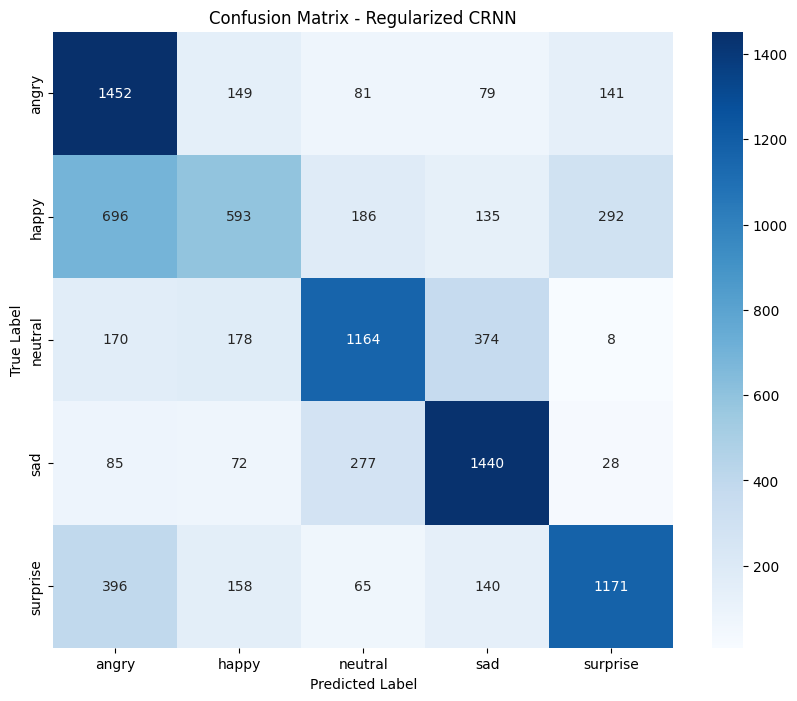

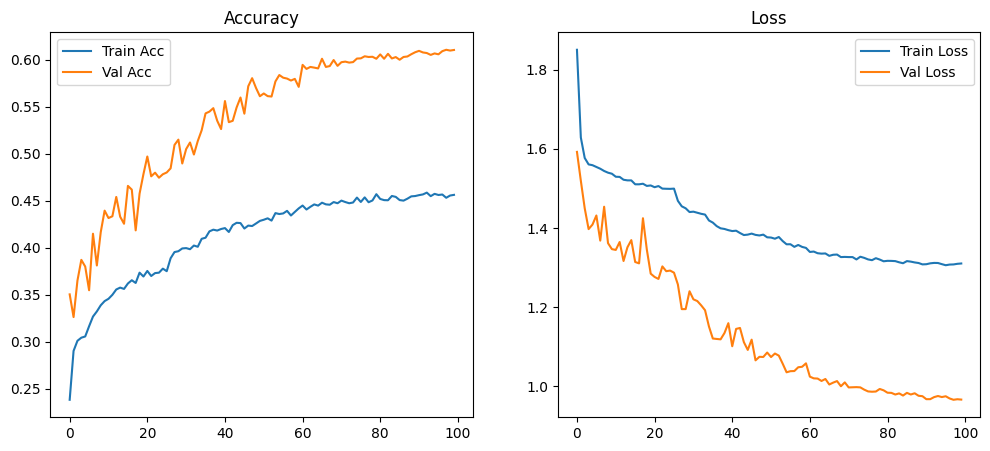


💾 Results saved to 'crnn_regularized_predictions.csv'


In [3]:
# ==========================================
# STRATEGY C: REGULARIZED GRU + ROBUST SPECAUGMENT
# ==========================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# ==========================================
# 1. DATA LOADING
# ==========================================
def load_real_data(features_file='/content/drive/MyDrive/unified_audio_features.h5'):
    print(f"📥 Loading data from {features_file}...")

    if not os.path.exists(features_file):
        raise FileNotFoundError(f"❌ Error: File '{features_file}' not found.")

    with h5py.File(features_file, 'r') as hf:
        features = hf['features'][:]
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]

    # Expand dims for channel (e.g., 128, 128) -> (128, 128, 1)
    features = np.expand_dims(features, axis=-1)

    # Re-encode labels
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    num_classes = len(np.unique(emotion_labels))
    onehot_labels = keras.utils.to_categorical(emotion_labels, num_classes)

    print(f"✅ Data Loaded: {features.shape} samples")
    return features, onehot_labels, label_encoder, num_classes

# ==========================================
# 2. ROBUST SPECAUGMENT IMPLEMENTATION
# ==========================================
def spec_augment(spectrogram, num_freq_masks=2, num_time_masks=2, freq_mask_param=15, time_mask_param=20):
    """
    Applies SpecAugment with safety checks for small dimensions.
    """
    aug_spectrogram = tf.identity(spectrogram)
    shape = tf.shape(aug_spectrogram)
    height = shape[0]
    width = shape[1]

    # Cast params to int32
    freq_mask_param = tf.cast(freq_mask_param, tf.int32)
    time_mask_param = tf.cast(time_mask_param, tf.int32)

    # --- Frequency Masking ---
    for _ in range(num_freq_masks):
        # 🛡️ SAFETY FIX: Ensure mask height is never larger than image height - 1
        # If image is 13px high, mask can be at most 12px.
        safe_f_max = tf.maximum(1, tf.minimum(freq_mask_param, height - 1))

        f = tf.random.uniform([], minval=0, maxval=safe_f_max, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=height - f, dtype=tf.int32)

        mask_start = f0
        mask_end = f0 + f
        indices = tf.range(height)
        mask = (indices < mask_start) | (indices >= mask_end)
        mask = tf.reshape(mask, (height, 1, 1))
        mask = tf.cast(mask, aug_spectrogram.dtype)
        aug_spectrogram = aug_spectrogram * mask

    # --- Time Masking ---
    for _ in range(num_time_masks):
        # 🛡️ SAFETY FIX: Ensure mask width is never larger than image width - 1
        safe_t_max = tf.maximum(1, tf.minimum(time_mask_param, width - 1))

        t = tf.random.uniform([], minval=0, maxval=safe_t_max, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=width - t, dtype=tf.int32)

        mask_start = t0
        mask_end = t0 + t
        indices = tf.range(width)
        mask = (indices < mask_start) | (indices >= mask_end)
        mask = tf.reshape(mask, (1, width, 1))
        mask = tf.cast(mask, aug_spectrogram.dtype)
        aug_spectrogram = aug_spectrogram * mask

    return aug_spectrogram

def apply_spec_augment_wrapper(image, label):
    # Wrapper for tf.data pipeline
    return spec_augment(image), label

# ==========================================
# 3. REGULARIZED CRNN ARCHITECTURE
# ==========================================
def build_regularized_crnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- CNN Block (Feature Extraction) ---
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # --- Bridge to RNN ---
    # Permute to (Batch, Time, Freq, Channels)
    x = layers.Permute((2, 1, 3))(x)

    # Reshape: Combine Frequency and Channels into 'Features'
    target_shape = (-1, x.shape[2] * x.shape[3])
    x = layers.Reshape(target_shape=(x.shape[1], x.shape[2] * x.shape[3]))(x)

    # --- RNN Block (Regularized GRU) ---
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
    )(x)

    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=False, dropout=0.4, recurrent_dropout=0.0)
    )(x)

    # --- Output Block ---
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Regularized_CRNN_GRU")
    return model

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================
def main_training_pipeline():
    # A. Load Data
    try:
        X, y, label_encoder, num_classes = load_real_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # B. Split Data
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )

    print(f"🔹 Training Set: {X_train.shape}")
    print(f"🔹 Test Set:     {X_test.shape}")

    # C. Create TF Datasets
    BATCH_SIZE = 32

    # Train Dataset (With Safe Augmentation)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=1000)
    train_ds = train_ds.map(apply_spec_augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Test Dataset (No Augmentation)
    val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # D. Build Model
    input_shape = X_train.shape[1:]
    model = build_regularized_crnn(input_shape, num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # E. Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('crnn_best_model_regularized.keras', save_best_only=True, monitor='val_accuracy'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
    ]

    # F. Train
    print("\n🚀 Starting Training (Regularized GRU + SpecAugment)...")
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

    # ==========================================
    # 5. DETAILED EVALUATION
    # ==========================================
    print("\n" + "="*40)
    print("📊 FINAL EVALUATION METRICS")
    print("="*40)

    # Load best weights
    model.load_weights('crnn_best_model_regularized.keras')

    # Generate Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"✅ Overall Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"✅ Weighted Precision: {prec:.4f}")
    print(f"✅ Weighted Recall:    {rec:.4f}")
    print(f"✅ Weighted F1-Score:  {f1:.4f}")

    print("\n📋 CLASSIFICATION REPORT")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Regularized CRNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_regularized.png')
    plt.show()

    # Training History
    if history is not None:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.savefig('training_history_regularized.png')
        plt.show()

    # Save Predictions CSV
    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('crnn_regularized_predictions.csv', index=False)
    print(f"\n💾 Results saved to 'crnn_regularized_predictions.csv'")

if __name__ == "__main__":
    main_training_pipeline()